In [3]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Example: 1D Poisson equation, u''(x) = f(x) on [0,1], with u(0)=0, u(1)=0.
# Define f(x) (source term). For example, f(x) = -π^2 * sin(πx) has true solution u(x)=sin(πx) on [0,1] with zero boundary.
omega_true = 2*np.pi    # undamped frequency
zeta_true  = 0.1       # damping ratio
A   = 0.5          # new amplitude
phi = 1.2          # new phase in radians
omega_d = omega_true*np.sqrt(1-zeta_true**2)
t0 = torch.zeros((1, 1), device=device, dtype=torch.float32)  # no grads needed
x0_val = A * math.cos(phi)                     # scalar Python float
v0_val = -A * zeta_true * omega_true * math.cos(phi)  \
        - A * omega_d      * math.sin(phi)
x0 = torch.tensor([[x0_val ]], device=device, dtype=torch.float32)
v0 = torch.tensor([[v0_val]], device=device, dtype=torch.float32)

In [5]:
# Analytical solution function
def x_true(t):
    # Underdamped solution: A*exp(-zeta*omega*t) * cos(omega_d*t + phi)
    return A * np.exp(-zeta_true*omega_true*t) * np.cos(omega_d*t + phi)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return 0

In [14]:
data_noise = 0.08

pde = DampedOscillator1D(
    zeta_true,
    omega_true, 
    f_func, 
    (x0, v0),
    (0, 5),
    x_true)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,5)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 5.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

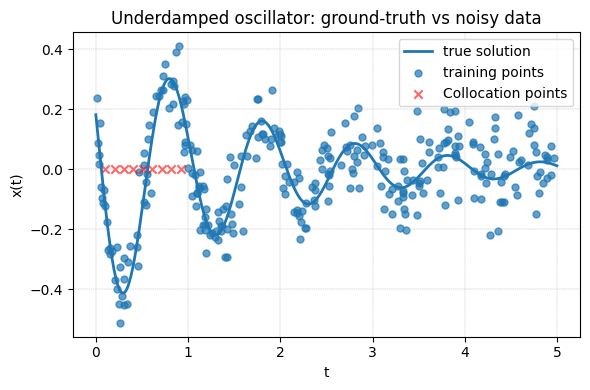

In [16]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 5,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=x_true,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [48]:
# from draft import VIBPINN
vi_oscillation_model = VIBPINN(pde, 1, [16, 32, 32, 16], 1, mu_std=0.05, rho=-3, prior_std=1000.0, init_data_noise=data_noise, learn_data_noise=False)
loss_dict = vi_oscillation_model.fit_vi_bpinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=100000, lr=6e-3,
                               λ_pde=10.0,λ_ic=10.0, λ_elbo=1.0, stop_schedule=20000)

ep     0 | L=7.45e+02 | elbo=6.51e+02 | pde=1.83e-01  ic=9.22e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep     1 | L=1.24e+03 | elbo=1.14e+03 | pde=3.30e-02  ic=9.22e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep  1000 | L=1.65e+03 | elbo=6.20e+02 | pde=9.33e+01  ic=9.21e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep  2000 | L=7.97e+02 | elbo=6.20e+02 | pde=8.37e+00  ic=9.25e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep  3000 | L=7.21e+02 | elbo=6.25e+02 | pde=3.07e-01  ic=9.25e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep  4000 | L=7.03e+02 | elbo=6.09e+02 | pde=1.18e-01  ic=9.24e+00  bc=0.00e+00 | lr=6.00e-03 | learned noise_std=8.000e-02
ep  5000 | L=7.08e+02 | elbo=6.10e+02 | pde=5.22e-01  ic=9.29e+00  bc=0.00e+00 | lr=3.00e-03 | learned noise_std=8.000e-02
ep  6000 | L=6.95e+02 | elbo=5.93e+02 | pde=7.67e-01  ic=9.48e+00  bc=0.00e+00 | lr=3.00e-03 | learned noise_std=8.000e-02
ep  7000 | L=6.4

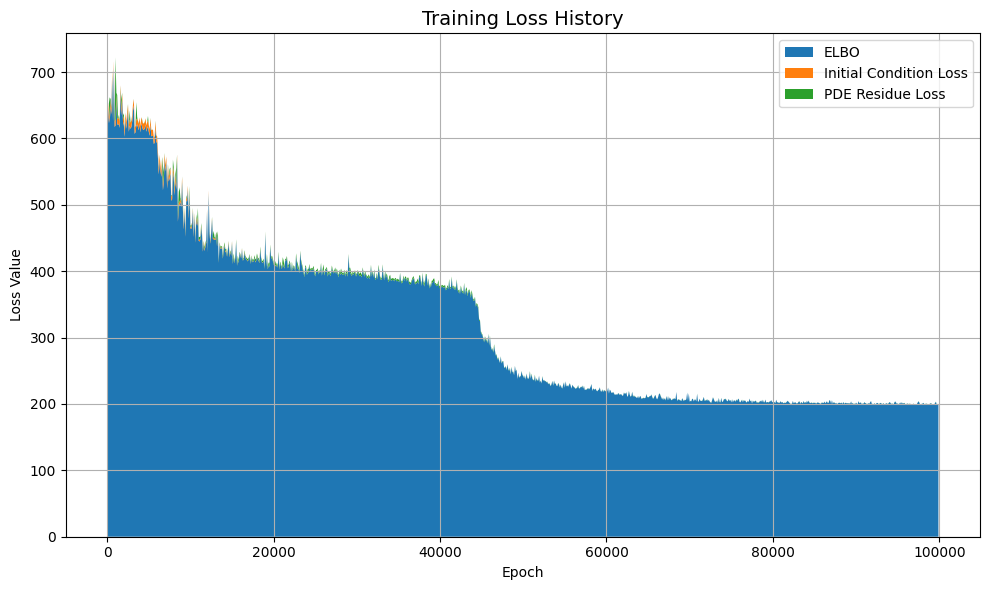

In [49]:
plot_training_history(loss_dict, plot_after=0, step=100)

In [61]:
x_grid = torch.linspace(0, 5, 100).view(-1, 1)
pred_set = vi_oscillation_model.predict(x_grid, n_samples=1000, z_score=1.69)

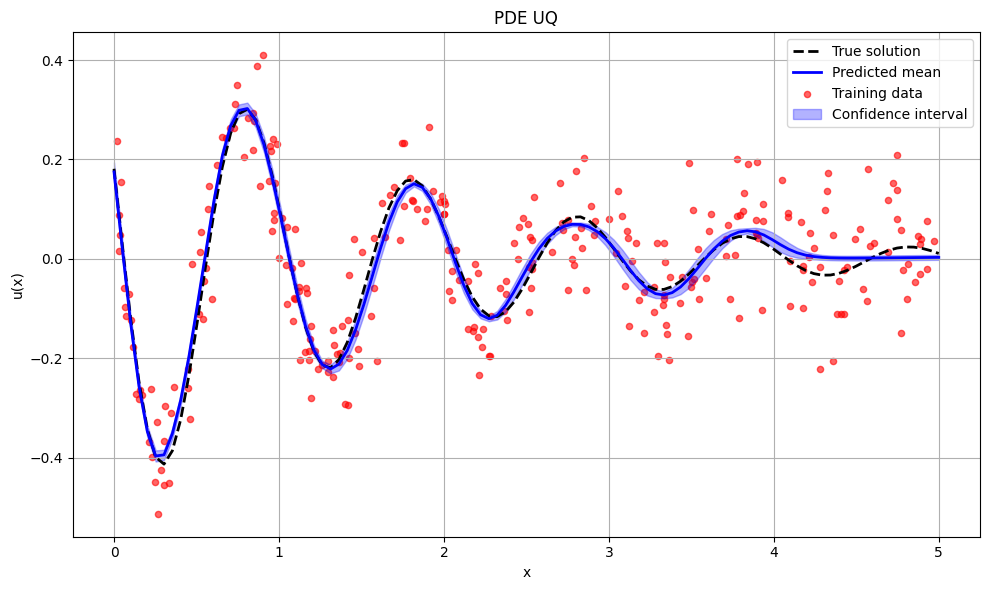

In [62]:
plot_predictions_1D(x_grid, pred_set, x_true, X=X_train, Y=Y_train)